In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# load and clean-up data
from numpy import nan
from pandas import read_csv
# univariate multi-step lstm
# import library 
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


## Preparing Data

In [4]:
# read data
data = pd.read_excel(r'/content/drive/MyDrive/TA (1)/Processing Data/Data/raw data/data_after_cleansing.xlsx',sheet_name="Masalembo")
data

,Date,Hours,Hs [m],Angin [m/s]
0,1998-10-30 04:00:00,1,0.250,3.278009
1,1998-10-30 05:00:00,2,0.250,2.625278
2,1998-10-30 06:00:00,3,0.250,2.227879
3,1998-10-30 07:00:00,4,0.250,2.528553
4,1998-10-30 08:00:00,5,0.250,2.701536
...,...,...,...,...
317,1998-11-12 09:00:00,318,0.719,8.174294
318,1998-11-12 10:00:00,319,0.719,8.394081
319,1998-11-12 11:00:00,320,0.719,8.687118
320,1998-11-12 12:00:00,321,0.656,8.901080


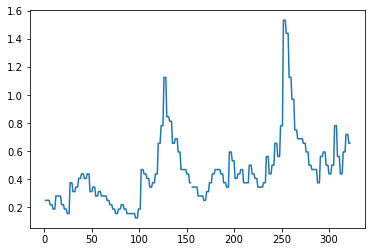

In [5]:
# plotting raw data
plt.plot(data['Hours'],data['Hs [m]'])
plt.show()

In [6]:
import copy
data_raw = copy.deepcopy(data)

### handling outliers

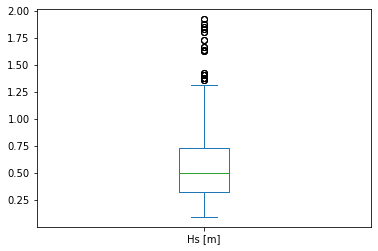

In [ ]:
data['Hs [m]'].plot(kind='box', sharex=False, sharey=False)
plt.show()

In [ ]:
# calculate q1, q3, iqr 
q1 = data['Hs [m]'].quantile(0.25)
q3 = data['Hs [m]'].quantile(0.75)
iqr = q3 - q1

In [ ]:
data['Hs [m]'].loc[(data['Hs [m]']> q3+(1.5*iqr)) & (data['Hs [m]']<= q3+(3*iqr)) ]

624     1.828
625     1.828
626     1.828
627     1.922
628     1.922
629     1.922
630     1.734
631     1.734
632     1.734
633     1.406
634     1.406
635     1.406
648     1.852
649     1.852
650     1.852
651     1.875
652     1.875
653     1.875
654     1.805
655     1.805
656     1.805
657     1.406
658     1.406
659     1.406
672     1.641
673     1.641
674     1.641
675     1.383
676     1.383
677     1.383
1449    1.383
1450    1.383
1451    1.383
1497    1.664
1498    1.664
1499    1.664
1500    1.359
1501    1.359
1502    1.359
2049    1.625
2050    1.625
2051    1.625
2277    1.422
2278    1.422
2279    1.422
Name: Hs [m], dtype: float64

In [ ]:
# outlier atas
data['Hs [m]'].loc[(data['Hs [m]']> q3+(1.5*iqr)) & (data['Hs [m]']<= q3+(3*iqr)) ] = np.nan

#outlier bawah
data['Hs [m]'].loc[(data['Hs [m]']< q1-(1.5*iqr)) & (data['Hs [m]']>= q1-(3*iqr)) ] = np.nan

# nilai ekstrim bawah
data['Hs [m]'].loc[data['Hs [m]']> q3 + (3*iqr) ] = np.nan

# nilai ekstrim atas
data['Hs [m]'].loc[data['Hs [m]']< q1 - (3*iqr) ] = np.nan

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
data.head()

,Date,Hours,Hs [m],Angin [m/s]
0,1999-01-12 00:00:00,1,0.281,3.450012
1,1999-01-12 01:00:00,2,0.281,3.195916
2,1999-01-12 02:00:00,3,0.281,3.480425
3,1999-01-12 03:00:00,4,0.234,3.734589
4,1999-01-12 04:00:00,5,0.234,3.478974


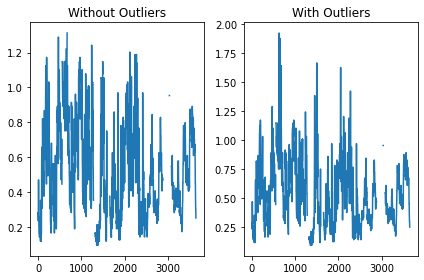

In [ ]:
plt.subplot(121)
plt.plot(data['Hs [m]'])
plt.title('Without Outliers')

plt.subplot(122)
plt.plot(data_raw['Hs [m]'])
plt.title('With Outliers')

plt.tight_layout()

### Interpolation

In [7]:
# import library
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [8]:
# define other dataframe for interpolate 
data2 = copy.deepcopy(data)
data3 = copy.deepcopy(data)
data4 = copy.deepcopy(data)

In [9]:
# drop NaN value in dataframe data
data = data.dropna()

In [10]:
# cubic interpolation
y_fc=interp1d(data['Hours'],data['Hs [m]'], kind='cubic')

In [11]:
# quadratic interpolation
y_fq=interp1d(data['Hours'],data['Hs [m]'], kind='quadratic')

In [12]:
y_fc=CubicSpline(data['Hours'],data['Hs [m]'],extrapolate=True)

In [13]:
# linear interpolation
y_fl=interp1d(data['Hours'],data['Hs [m]'], kind='linear')

In [14]:
# interpolate using function we define before
import math

for i in data2['Hours'] :
  if math.isnan(data2['Hs [m]'][i-1])== True:
    data2['Hs [m]'][i-1] = y_fc(i)
    data3['Hs [m]'][i-1] = y_fq(i)
    data4['Hs [m]'][i-1] = y_fl(i)
  else:
    pass
#data.loc[data['Hs [m]'].isna()]

<ipython-input-14-86623d2f7eed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Hs [m]'][i-1] = y_fc(i)
<ipython-input-14-86623d2f7eed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['Hs [m]'][i-1] = y_fq(i)
<ipython-input-14-86623d2f7eed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['Hs [m]'][i-1] = y_fl(i)


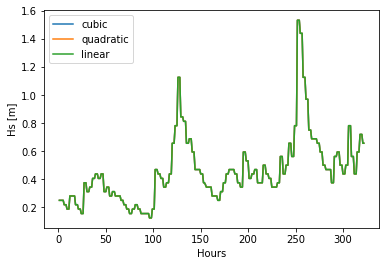

In [15]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
plt.plot(data3['Hours'],data3['Hs [m]'], label ='quadratic')
plt.plot(data4['Hours'],data4['Hs [m]'], label ='linear')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

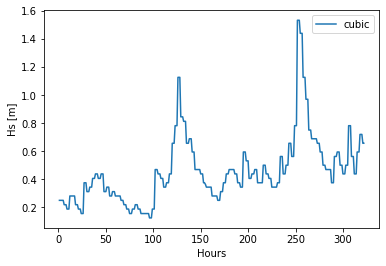

In [16]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

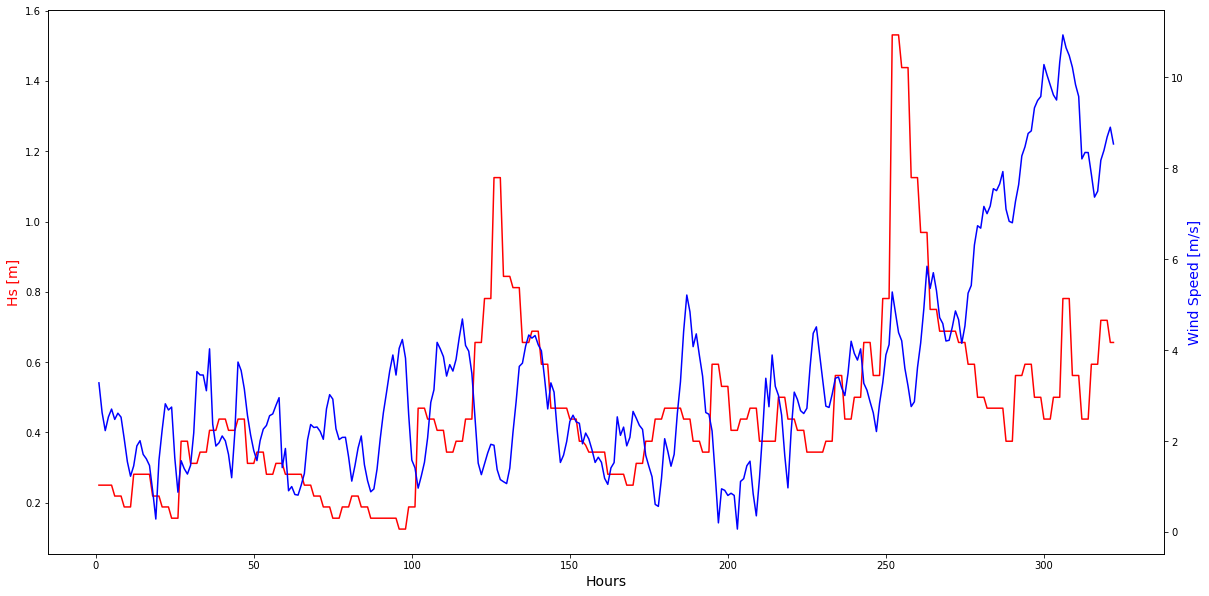

In [17]:
# plotting wind and wave
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(20, 10))
# make a plot
ax.plot(data2['Hours'],
        data2['Hs [m]'],
        color="red", 
        )
# set x-axis label
ax.set_xlabel("Hours", fontsize = 14)
# set y-axis label
ax.set_ylabel("Hs [m]",
              color="red",
              fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data2['Hours'],
        data2['Angin [m/s]'],color="blue")
ax2.set_ylabel("Wind Speed [m/s]",color="blue",fontsize=14)
plt.show()

karena data tidak berdistribusi normal -> ada skew nya (positif) makanya buat scaling data pake -> Normalize Data

### splitting data

In [18]:
data_swh = data2['Hs [m]']
type(data_swh), data_swh.shape

(pandas.core.series.Series, (322,))

In [19]:
len(data_swh)

322

In [ ]:
data_swh[1:5]

1    0.281
2    0.281
3    0.234
4    0.234
Name: Hs [m], dtype: float64

In [ ]:
data_swh[5:8]

5    0.688
6    0.562
7    0.562
Name: Hs [m], dtype: float64

**Pembagian data**

train = data 70% --> 1 - 2556

val = data 10% --> 2557 - 2928

test = data 20% --> 2929 - 3648

In [20]:
train = data_swh[:216]
val = data_swh[216:252]
test = data_swh[252:312]
train.shape, val.shape, test.shape

((216,), (36,), (60,))

In [21]:
# resturvture into windows of 12 hours data
train = array(split(train, round(len(train)/12)))
val = array(split(val, round(len(val)/12)))
test = array(split(test, round(len(test)/12)))
train.shape, val.shape, test.shape

((18, 12), (3, 12), (5, 12))

In [22]:
n_input,n_out = 12,12
data_train = train.reshape((train.shape[0]*train.shape[1], ))
data_val = val.reshape((val.shape[0]*val.shape[1], ))
data_train.shape, data_val.shape

((216,), (36,))

In [23]:
len(data_train)

216

In [24]:
def split_into_xy(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [25]:
n_steps_in, n_steps_out = 12, 12
X_train, y_train = split_into_xy(data_train,n_steps_in, n_steps_out)
X_val, y_val = split_into_xy(data_val,n_steps_in, n_steps_out)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((193, 12), (193, 12), (13, 12), (13, 12))

In [26]:
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_train.shape,X_val.shape

((193, 12, 1), (13, 12, 1))

## Model

In [186]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# define model
model = Sequential()
model.add(LSTM(240, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(180, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(120, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(36, activation='relu')))
model.add(TimeDistributed(Dense(1)))

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 240)               232320    
                                                                 
 repeat_vector_37 (RepeatVec  (None, 12, 240)          0         
 tor)                                                            
                                                                 
 lstm_54 (LSTM)              (None, 180)               303120    
                                                                 
 repeat_vector_38 (RepeatVec  (None, 12, 180)          0         
 tor)                                                            
                                                                 
 lstm_55 (LSTM)              (None, 12, 120)           144480    
                                                                 
 time_distributed_32 (TimeDi  (None, 12, 36)         

In [187]:
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [188]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1])

Epoch 1/100
6/7 [========================>.....] - ETA: 0s - loss: 0.1803 - root_mean_squared_error: 0.4246

7/7 [==============================] - 13s 1s/step - loss: 0.1802 - root_mean_squared_error: 0.4245 - val_loss: 0.2942 - val_root_mean_squared_error: 0.5424
Epoch 2/100
6/7 [========================>.....] - ETA: 0s - loss: 0.1704 - root_mean_squared_error: 0.4127

7/7 [==============================] - 5s 804ms/step - loss: 0.1709 - root_mean_squared_error: 0.4134 - val_loss: 0.2811 - val_root_mean_squared_error: 0.5302
Epoch 3/100
6/7 [========================>.....] - ETA: 0s - loss: 0.1621 - root_mean_squared_error: 0.4026

7/7 [==============================] - 6s 1s/step - loss: 0.1615 - root_mean_squared_error: 0.4019 - val_loss: 0.2655 - val_root_mean_squared_error: 0.5153
Epoch 4/100
6/7 [========================>.....] - ETA: 0s - loss: 0.1497 - root_mean_squared_error: 0.3870

7/7 [==============================] - 5s 879ms/step - loss: 0.1496 - root_mean_squared_error: 0.3867 - val_loss: 0.2450 - val_root_mean_squared_error: 0.4950
Epoch 5/100
6/7 [========================>.....] - ETA: 0s - loss: 0.1337 - root_mean_squared_error: 0.3656

7/7 [==============================] - 5s 840ms/step - loss: 0.1337 - root_mean_squared_error: 0.3657 - val_loss: 0.2151 - val_root_mean_squared_error: 0.4638
Epoch 6/100
6/7 [========================>.....] - ETA: 0s - loss: 0.1105 - root_mean_squared_error: 0.3325

7/7 [==============================] - 7s 1s/step - loss: 0.1106 - root_mean_squared_error: 0.3326 - val_loss: 0.1704 - val_root_mean_squared_error: 0.4128
Epoch 7/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0793 - root_mean_squared_error: 0.2816

7/7 [==============================] - 5s 790ms/step - loss: 0.0789 - root_mean_squared_error: 0.2810 - val_loss: 0.1074 - val_root_mean_squared_error: 0.3277
Epoch 8/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0497 - root_mean_squared_error: 0.2229

7/7 [==============================] - 5s 876ms/step - loss: 0.0495 - root_mean_squared_error: 0.2226 - val_loss: 0.0456 - val_root_mean_squared_error: 0.2136
Epoch 9/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0461 - root_mean_squared_error: 0.2148

7/7 [==============================] - 6s 971ms/step - loss: 0.0460 - root_mean_squared_error: 0.2144 - val_loss: 0.0445 - val_root_mean_squared_error: 0.2110
Epoch 10/100
7/7 [==============================] - 0s 64ms/step - loss: 0.0419 - root_mean_squared_error: 0.2047 - val_loss: 0.0562 - val_root_mean_squared_error: 0.2370
Epoch 11/100
7/7 [==============================] - 0s 63ms/step - loss: 0.0416 - root_mean_squared_error: 0.2040 - val_loss: 0.0688 - val_root_mean_squared_error: 0.2622
Epoch 12/100
7/7 [==============================] - 0s 59ms/step - loss: 0.0416 - root_mean_squared_error: 0.2040 - val_loss: 0.0614 - val_root_mean_squared_error: 0.2478
Epoch 13/100
7/7 [==============================] - 0s 61ms/step - loss: 0.0392 - root_mean_squared_error: 0.1980 - val_loss: 0.0523 - val_root_mean_squared_error: 0.2287
Epoch 14/100
7/7 [==============================] - 0s 62ms/step - loss: 0.0383 - root_mean_squared_error: 0.1957 - val_loss: 0.0509 - val_root_mean_squared_

7/7 [==============================] - 5s 863ms/step - loss: 0.0353 - root_mean_squared_error: 0.1879 - val_loss: 0.0424 - val_root_mean_squared_error: 0.2059
Epoch 21/100
7/7 [==============================] - 0s 63ms/step - loss: 0.0349 - root_mean_squared_error: 0.1869 - val_loss: 0.0426 - val_root_mean_squared_error: 0.2065
Epoch 22/100
7/7 [==============================] - 0s 64ms/step - loss: 0.0345 - root_mean_squared_error: 0.1858 - val_loss: 0.0449 - val_root_mean_squared_error: 0.2119
Epoch 23/100
7/7 [==============================] - 0s 60ms/step - loss: 0.0340 - root_mean_squared_error: 0.1844 - val_loss: 0.0431 - val_root_mean_squared_error: 0.2075
Epoch 24/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0334 - root_mean_squared_error: 0.1826

7/7 [==============================] - 5s 854ms/step - loss: 0.0333 - root_mean_squared_error: 0.1824 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1960
Epoch 25/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0331 - root_mean_squared_error: 0.1819

7/7 [==============================] - 9s 1s/step - loss: 0.0329 - root_mean_squared_error: 0.1815 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1955
Epoch 26/100
7/7 [==============================] - 0s 59ms/step - loss: 0.0323 - root_mean_squared_error: 0.1796 - val_loss: 0.0415 - val_root_mean_squared_error: 0.2038
Epoch 27/100
7/7 [==============================] - 0s 62ms/step - loss: 0.0312 - root_mean_squared_error: 0.1767 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1958
Epoch 28/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0314 - root_mean_squared_error: 0.1773

7/7 [==============================] - 5s 817ms/step - loss: 0.0314 - root_mean_squared_error: 0.1771 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1597
Epoch 29/100
7/7 [==============================] - 1s 99ms/step - loss: 0.0317 - root_mean_squared_error: 0.1781 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1863
Epoch 30/100
7/7 [==============================] - 1s 97ms/step - loss: 0.0288 - root_mean_squared_error: 0.1696 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2030
Epoch 31/100
7/7 [==============================] - 1s 75ms/step - loss: 0.0283 - root_mean_squared_error: 0.1683 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1865
Epoch 32/100
7/7 [==============================] - 0s 64ms/step - loss: 0.0272 - root_mean_squared_error: 0.1650 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1808
Epoch 33/100
7/7 [==============================] - 0s 62ms/step - loss: 0.0267 - root_mean_squared_error: 0.1634 - val_loss: 0.0362 - val_root_mean_squared_

7/7 [==============================] - 6s 937ms/step - loss: 0.0252 - root_mean_squared_error: 0.1589 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1569
Epoch 43/100
7/7 [==============================] - 1s 99ms/step - loss: 0.0252 - root_mean_squared_error: 0.1588 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1874
Epoch 44/100
7/7 [==============================] - 1s 100ms/step - loss: 0.0246 - root_mean_squared_error: 0.1568 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1992
Epoch 45/100
7/7 [==============================] - 1s 100ms/step - loss: 0.0246 - root_mean_squared_error: 0.1570 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1977
Epoch 46/100
7/7 [==============================] - 1s 79ms/step - loss: 0.0244 - root_mean_squared_error: 0.1562 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1930
Epoch 47/100
7/7 [==============================] - 0s 59ms/step - loss: 0.0241 - root_mean_squared_error: 0.1553 - val_loss: 0.0357 - val_root_mean_square

7/7 [==============================] - 5s 886ms/step - loss: 0.0202 - root_mean_squared_error: 0.1420 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1506
Epoch 89/100
7/7 [==============================] - 1s 101ms/step - loss: 0.0259 - root_mean_squared_error: 0.1610 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1687
Epoch 90/100
7/7 [==============================] - 0s 57ms/step - loss: 0.0205 - root_mean_squared_error: 0.1431 - val_loss: 0.0456 - val_root_mean_squared_error: 0.2134
Epoch 91/100
7/7 [==============================] - 0s 59ms/step - loss: 0.0213 - root_mean_squared_error: 0.1459 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1750
Epoch 92/100
7/7 [==============================] - 0s 60ms/step - loss: 0.0202 - root_mean_squared_error: 0.1422 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1572
Epoch 93/100
7/7 [==============================] - 0s 60ms/step - loss: 0.0199 - root_mean_squared_error: 0.1410 - val_loss: 0.0331 - val_root_mean_squared

7/7 [==============================] - 5s 755ms/step - loss: 0.0206 - root_mean_squared_error: 0.1435 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1456
Epoch 99/100
7/7 [==============================] - 0s 61ms/step - loss: 0.0225 - root_mean_squared_error: 0.1500 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1623
Epoch 100/100
7/7 [==============================] - 0s 61ms/step - loss: 0.0211 - root_mean_squared_error: 0.1451 - val_loss: 0.0465 - val_root_mean_squared_error: 0.2157


In [189]:
from tensorflow.keras.models import load_model
model = load_model('model/')

In [190]:
history = [x for x in val]
predictions = list()
for i in range(len(test)):
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], ))
  input_x = data[-n_input:, ]
  input_x = input_x.reshape((1, len(input_x), 1))
  # predict the week
  yhat = model.predict(input_x, verbose=0)
  yhat_sequence = yhat[0]
  # store the predictions
  predictions.append(yhat_sequence)
  # get real observation and add to history for predicting the next week
  history.append(test[i, :])

In [191]:
prediksi = array(predictions)
observasi = test
prediksi = prediksi.reshape((prediksi.shape[0]*prediksi.shape[1], 1))
observasi = observasi.reshape((observasi.shape[0]*observasi.shape[1], 1))

In [192]:
import pandas as pd
test_results = pd.DataFrame(data={'Univariate':prediksi.flatten(), 
                                   'Actuals':observasi.flatten()})
test_results.shape

(60, 2)

In [193]:
prediksi = array(predictions)
observasi = test[:, :, ]
prediksi = prediksi.reshape((prediksi.shape[0]*prediksi.shape[1], 1))
observasi = observasi.reshape((observasi.shape[0]*observasi.shape[1], 1))

In [194]:
test_results['Date'] = data2['Date'].iloc[252:312].values
test_results.head()

,Univariate,Actuals,Date
0,0.982393,1.531,1998-11-09 16:00:00
1,1.050856,1.531,1998-11-09 17:00:00
2,0.968732,1.438,1998-11-09 18:00:00
3,0.941388,1.438,1998-11-09 19:00:00
4,0.906235,1.438,1998-11-09 20:00:00


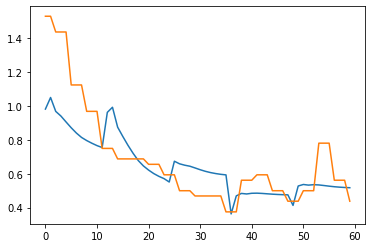

In [195]:
plt.plot(test_results['Univariate'])
plt.plot(test_results['Actuals'])

In [196]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Univariate'],
                    mode='lines',
                    name='Fitting Data Testing'))
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Actuals'],
                    mode='lines',fillcolor='#ff0000',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [197]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(test_results['Actuals'],test_results['Univariate'])
RMSE = math.sqrt(MSE)
RMSE

0.19724411691355548

In [198]:
from scipy.stats import pearsonr
corr, _ = pearsonr(test_results['Actuals'],test_results['Univariate'])
corr

0.7975839647149957

In [199]:
# bias 
gap_sum = 0
for j in range(len(test_results['Actuals'])):
  gap = test_results['Univariate'][j] - test_results['Actuals'][j]
  gap_sum += gap

bias = gap_sum/len(test_results['Actuals'])
bias

-0.04728803424437839

In [200]:
test_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multi-step/univariate_12jam_lstm_masalembo.csv')